# DC motor PID tuning

In [13]:
import os, sys
import time
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym

### Parameters of the simulation

In [21]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        self.init_states = {}
        super().__init__(config)

    def _get_info(self):
        return {'info_time':time.time()}

    # possibility to do processing of FMU outputs to observations of the environment here
    def _get_obs(self):
        
        self._get_fmu_output()

        obs = np.array(list(self.observation.values())).flatten()
        
        noisy_observation = obs + self._get_output_noise()

        obs_dict = np.array(noisy_observation)
        return obs_dict
    
    def _get_input_noise(self):
        input_noise = []
        for inp_name in self.input_dict:
            input_noise.append(self.input_noise[inp_name].sample()[0])
        return np.array(input_noise)

    def _get_output_noise(self):
        output_noise = []
        for out_name in self.output_dict:
                output_noise.append(self.output_noise[out_name].sample()[0])
        return np.array(output_noise)

    def _get_terminated(self):
        if self.time > self.stop_time:
            self.reset()
            return True, False

        for termination in self.terminations:
            min_value = self.terminations[termination].low[0]
            max_value = self.terminations[termination].high[0]
            if self.observation[termination] < min_value or self.observation[termination] > max_value:
                self.reset()
                return False, True

        return False, False

    def _create_action_space(self, inputs):
        lows = []
        highs = []
        for inp in inputs:
            lows.append(inputs[inp].low[0])
            highs.append(inputs[inp].high[0])
        action_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return action_space
    
    def _create_observation_space(self, outputs):
        lows = []
        highs = []
        for out in outputs:
            lows.append(outputs[out].low[0])
            highs.append(outputs[out].high[0])
        observation_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return observation_space

    def _noisy_init(self):
        # add noise to initial system state
        init_states = {}
        for var in self.random_vars_refs:
            var_ref = self.random_vars_refs[var][0]
            uniform_value = self.random_vars_refs[var][1].sample()[0]
            self.init_states[var_ref] = uniform_value
        return self.init_states

    def _process_action(self, action):
        processed_action = action + self._get_input_noise()
        return processed_action

    # collect current values of randomized parameters with parameter_refs and store them in self.random_vars_refs
    def get_random_vars(self):
        params = {key: self.init_states[value[0]] for key, value in self.random_vars_refs.items()}
        return params

    def _process_reward(self, obs, acts, info):
        reward = self.compute_reward(obs, info)
        return reward
    
    def compute_reward(self, obs, info):
        reward = -np.abs(obs[0])
        return reward
    
    def set_PID_params(self, k, Ti, Td):
        self.random_vars_refs["speedController.k"][1].low = np.array([k])
        self.random_vars_refs["speedController.k"][1].high = np.array([k])
        self.random_vars_refs["speedController.Ti"][1].low = np.array([Ti])
        self.random_vars_refs["speedController.Ti"][1].high = np.array([Ti])
        self.random_vars_refs["speedController.Td"][1].low = np.array([Td])
        self.random_vars_refs["speedController.Td"][1].high = np.array([Td])

In [23]:
inputs = VarSpace("inputs")
inputs.add_var_box("in_torque", -10.0, 10.0)

input_noise = VarSpace("input_noise")
input_noise.add_var_box("in_torque", 0.0, 0.0)

outputs = VarSpace("outputs")
outputs.add_var_box("out_control_err", -1e6, 1e6)
outputs.add_var_box("out_load_speed", -1e6, 1e6)
outputs.add_var_box("out_motor_speed", -1e6, 1e6)

output_noise = VarSpace("output_noise")
output_noise.add_var_box("out_control_err", 0.0, 0.0)
output_noise.add_var_box("out_load_speed", 0.0, 0.0)
output_noise.add_var_box("out_motor_speed", 0.0, 0.0)

# dynamics and domain randomization
random_vars = VarSpace("random_vars")
# random_vars.add_var_box("damper.d", 100.0, 1000.0)
# random_vars.add_var_box("spring.k", 1.0, 100.0)
random_vars.add_var_box("speedController.k", 100.0, 100.0)
random_vars.add_var_box("speedController.Ti", 0.1, 0.1)
random_vars.add_var_box("speedController.Td", 0.1, 0.1)

#terminations = VarSpace("terminations")

config = FMUGymConfig(fmu_path=os.path.abspath('DC_motor_workshop/DC_motor.fmu'),
                      start_time=0.0,
                      stop_time=6.0,
                      sim_step_size=0.01,
                      action_step_size=0.01,
                      inputs=inputs,
                      input_noise=input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                     )                        

In [24]:
model_description = read_model_description(config.fmu_path)
print(model_description)

ModelDescription(fmiVersion='2.0', modelName='Credibility.Examples.SimpleControlledDriveNonlinear.DC_Motor_Monte_Carlo', coSimulation=CoSimulation(modelIdentifier='DC_motor'), modelExchange=None, scheduledExecution=None)


### Creation of gym environment

In [25]:
dummyEnv = FMUEnv(config)

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF


### 5 Simulation of one episode with specific PID gains

In [26]:
print(dummyEnv.get_random_vars())

{'speedController.Td': 0.1, 'speedController.Ti': 0.1, 'speedController.k': 100.0}


In [27]:
print(dummyEnv.output_dict)

{'out_control_err': 51, 'out_load_speed': 52, 'out_motor_speed': 53}


In [30]:
dummyEnv.get_random_vars()

{'speedController.Td': 0.1,
 'speedController.Ti': 0.1,
 'speedController.k': 10.0}

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF
MSE:  4.933412e-05


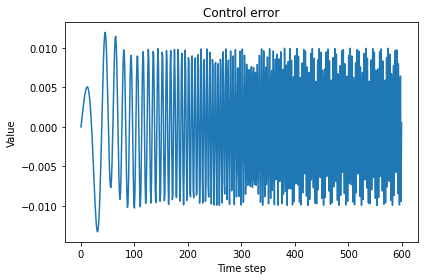

In [29]:
### PID parameters
dummyEnv.set_PID_params(10, 0.1, 0.1)

# Simulation
num_steps_per_episode = int((config.stop_time - config.start_time) / config.sim_step_size)

observation, info = dummyEnv.reset()
obs_episode = [observation]

# capturing trajectories here
for k in range(num_steps_per_episode):
    action = 0
    observation, reward, terminated, truncated, info = dummyEnv.step(action)
    obs_episode.append(observation)

obs_episode = np.array(obs_episode)
mean_squared_errors = (obs_episode**2).mean(axis=0)[0]
print("MSE: ", mean_squared_errors)

plt.figure()

plt.plot(obs_episode[:, 0])

plt.title(f"Control error")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.tight_layout()
plt.show()